In [54]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import pickle
from numpy import genfromtxt
import pandas as pd
from joblib import Parallel, delayed
import multiprocessing as mp
import scipy.io
from tqdm import tqdm_notebook as tqdm
import h5py
import math

In [55]:
import sys
from mgcpy.independence_tests.dcorr import DCorr
from mgcpy.benchmarks.hypothesis_tests.two_sample_test.power_dimension import power_given_data
from mgcpy.benchmarks.simulations import *
from mgcpy.independence_tests.mgc import MGC
from mgcpy.independence_tests.rv_corr import RVCorr
from mgcpy.independence_tests.hhg import HHG
from mgcpy.independence_tests.kendall_spearman import KendallSpearman

In [56]:
simulations = {'linear': (linear_sim, 1), 'cubic': (cub_sim, 3), 'step': (step_sim, 5), 'quadratic': (quad_sim, 6)}
#{'linear': (linear_sim, 1), 'exponential': (exp_sim, 2), 'cubic': (cub_sim, 3), 'step': (step_sim, 5), 
               #'spiral': (spiral_sim, 8), 'quadratic': (quad_sim, 6), 'w_shape': (w_sim, 7), 'bernoulli': (ubern_sim, 9)}
#{'log': (log_sim, 10)} at 1.2
#{'multi_indept': (multi_indep_sim, 20), 'joint_normal': (joint_sim, 4), 'multi_noise': (multi_noise_sim, 19), } at 0.6
#{'sine_4pi': (sin_sim, 12), 'sine_16pi': (sin_sim, 13), 
              #'diamond': (square_sim, 18),  
              # 'square': (square_sim, 14)} at 0.5
#{'step': (step_sim, 5), 'spiral': (spiral_sim, 8), 'quadratic': (quad_sim, 6), 'w_shape': (w_sim, 7), 
               #'bernoulli': (ubern_sim, 9), 'linear': (linea_sim, 1), 'exponential': (exp_sim, 2), 'cubic': (cub_sim, 3)}

In [57]:
def power_vs_dimension_parallel(params_dict):
    dims = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    estimated_power = np.zeros(len(dims))
    test = params_dict['independence_test']
    sim = params_dict['simulation_type']
    print(sim, test.get_name())
    
    for i in range(len(dims)):
        estimated_power[i] = power_given_data(test, sim, num_samples=100, num_dimensions=dims[i], translate=0.5)
    
    np.savetxt('{}_{}_dimension_matlab_new.csv'.format(sim, test.get_name()), estimated_power, delimiter=',')
    print('{} {} finished'.format(sim, test.get_name()))
    return (params_dict, estimated_power)

In [58]:
def fill_params_dict_list_dim():
    mcorr = DCorr(which_test='unbiased')
    dcorr = DCorr(which_test='biased')
    mantel = DCorr(which_test='mantel')
    mgc = MGC()
    pearson = RVCorr(which_test='pearson')
    rv_corr = RVCorr(which_test='rv')
    cca = RVCorr(which_test='cca')
    independence_tests = [mcorr, dcorr, mantel, mgc, pearson, rv_corr, cca]
    
    params_dict_list = []
    for sim_name, sim_func in simulations.items():
        for test in independence_tests:
            params_dict = {'independence_test': test, 'simulation_type': sim_func[1]}
            params_dict_list.append(params_dict)
    return params_dict_list

In [59]:
%%time
params_dict = fill_params_dict_list_dim()
print(type(params_dict))
pool = mp.Pool(mp.cpu_count()-1)
results = pool.map(power_vs_dimension_parallel, params_dict)

<class 'list'>
1 cca
1 mgc
1 unbiased
1 cca finished
3 unbiased
1 unbiased finished
1 biased
3 unbiased finished
3 biased
1 biased finished
1 mantel
3 biased finished
3 mantel
1 mantel finished
3 rv
3 mantel finished
3 mgc
3 rv finished
3 cca
3 cca finished
5 unbiased
5 unbiased finished
5 biased
5 biased finished
5 mantel
5 mantel finished
5 mgc
1 mgc finished
1 pearson
1 pearson finished
1 rv
1 rv finished
5 pearson
5 pearson finished
5 rv
5 rv finished
5 cca
5 cca finished
6 unbiased
6 unbiased finished
6 biased
3 mgc finished
3 pearson
3 pearson finished
6 mgc
6 biased finished
6 mantel
6 mantel finished
6 cca
6 cca finished
5 mgc finished
6 mgc finished
6 pearson
6 pearson finished
6 rv
6 rv finished
CPU times: user 12.6 s, sys: 2.86 s, total: 15.4 s
Wall time: 5h 1min 58s


In [60]:
def plot_all_curves():
    simulation_names = ['linear', 'exponential', 'cubic', 'step', 'quadratic', 'w_shape', 'spiral', 
                         'bernoulli', 'fourth_root', 'two_parabolas', 'circle', 'ellipse']
    sim_array = [1,2,3,5,6,7,8,9,11,15,16,17]    
        
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(14,12)) 
    simmy=0
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            sim_name = simulation_names[simmy]
            simulation_type = sim_array[simmy]
            simmy += 1
            tests = ['mgc', 'unbiased', 'biased', 'mantel', 'pearson', 'rv', 'cca']
            #mgc_power = np.genfromtxt('{}_mgc_angle_matlab_new.csv'.format(simulation_type), delimiter=',')

            for test in tests:
                power = np.genfromtxt('{}_{}_dimension_matlab_new.csv'.format(simulation_type, test), delimiter=',')
                x_axis = [1,2,3,4,5,6,7,8,9,10]
                col.plot(x_axis, power, label=test)
                col.set_ylim(-0.25, 1.25)
                col.set_yticks([-0.25, 0, 0.25, 0.50, 0.75, 1.00])
                col.set_title(sim_name) 
    plt.legend()
    plt.subplots_adjust(hspace=.75)
    fig.suptitle('Power of Changing Dimension')
    plt.savefig('power_curves_dimension_trial')

ValueError: x and y must have same first dimension, but have shapes (10,) and (7,)

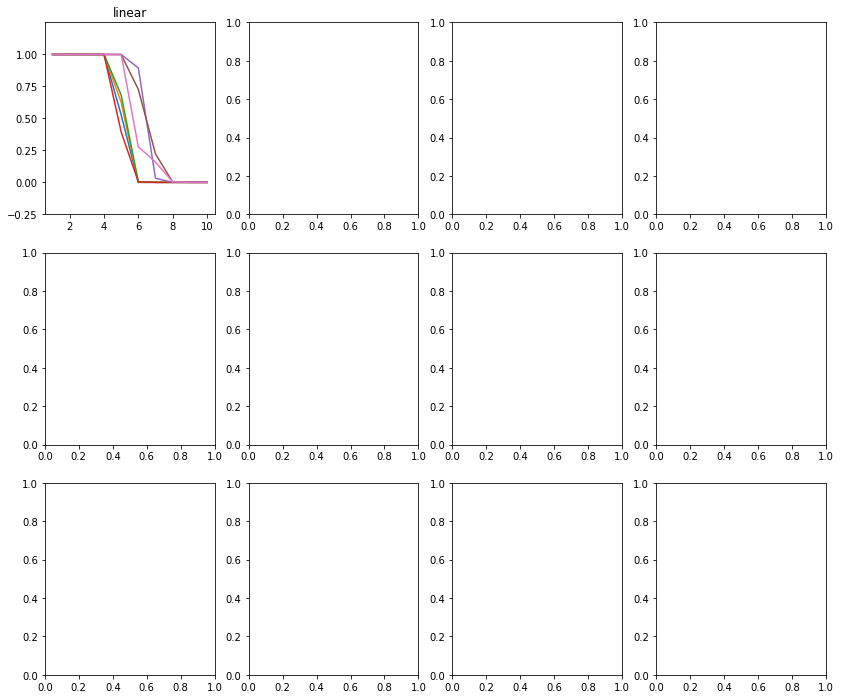

In [61]:
plot_all_curves()

In [62]:
simulations = {'exponential': (exp_sim, 2)}

In [63]:
def power_vs_dimension_parallel(params_dict):
    dims = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    estimated_power = np.zeros(len(dims))
    test = params_dict['independence_test']
    sim = params_dict['simulation_type']
    print(sim, test.get_name())
    
    for i in range(len(dims)):
        estimated_power[i] = power_given_data(test, sim, num_samples=100, num_dimensions=dims[i], translate=0.45)
    
    np.savetxt('{}_{}_dimension_matlab_new.csv'.format(sim, test.get_name()), estimated_power, delimiter=',')
    print('{} {} finished'.format(sim, test.get_name()))
    return (params_dict, estimated_power)

In [64]:
def fill_params_dict_list_dim():
    mcorr = DCorr(which_test='unbiased')
    dcorr = DCorr(which_test='biased')
    mantel = DCorr(which_test='mantel')
    mgc = MGC()
    pearson = RVCorr(which_test='pearson')
    rv_corr = RVCorr(which_test='rv')
    cca = RVCorr(which_test='cca')
    independence_tests = [mcorr, dcorr, mantel, mgc, pearson, rv_corr, cca]
    
    params_dict_list = []
    for sim_name, sim_func in simulations.items():
        for test in independence_tests:
            params_dict = {'independence_test': test, 'simulation_type': sim_func[1]}
            params_dict_list.append(params_dict)
    return params_dict_list

In [65]:
%%time
params_dict = fill_params_dict_list_dim()
print(type(params_dict))
pool = mp.Pool(mp.cpu_count()-1)
results = pool.map(power_vs_dimension_parallel, params_dict)

<class 'list'>
2 unbiased
2 biased
2 mantel
2 mantel finished
2 mgc
2 biased finished
2 pearson
2 unbiased finished
2 rv
2 pearson finished
2 cca
2 rv finished
2 cca finished
2 mgc finished
CPU times: user 2.24 s, sys: 533 ms, total: 2.78 s
Wall time: 1h 9min 48s


ValueError: x and y must have same first dimension, but have shapes (10,) and (7,)

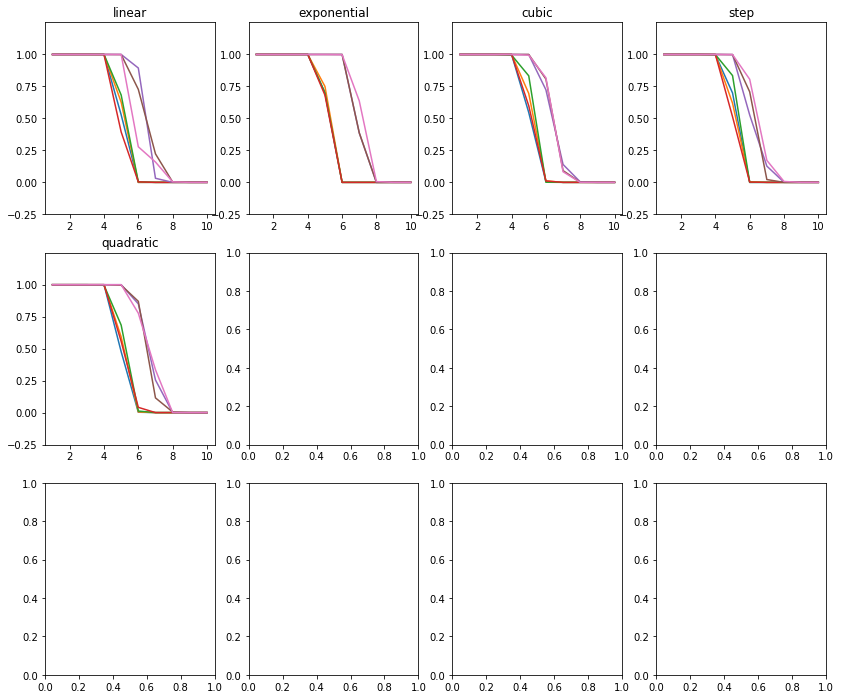

In [66]:
plot_all_curves()

In [67]:
simulations = {'w_shape': (w_sim, 7)}

In [68]:
def power_vs_dimension_parallel(params_dict):
    dims = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    estimated_power = np.zeros(len(dims))
    test = params_dict['independence_test']
    sim = params_dict['simulation_type']
    print(sim, test.get_name())
    
    for i in range(len(dims)):
        estimated_power[i] = power_given_data(test, sim, num_samples=100, num_dimensions=dims[i], translate=0.35)
    
    np.savetxt('{}_{}_dimension_matlab_new.csv'.format(sim, test.get_name()), estimated_power, delimiter=',')
    print('{} {} finished'.format(sim, test.get_name()))
    return (params_dict, estimated_power)

In [69]:
def fill_params_dict_list_dim():
    mcorr = DCorr(which_test='unbiased')
    dcorr = DCorr(which_test='biased')
    mantel = DCorr(which_test='mantel')
    mgc = MGC()
    pearson = RVCorr(which_test='pearson')
    rv_corr = RVCorr(which_test='rv')
    cca = RVCorr(which_test='cca')
    independence_tests = [mcorr, dcorr, mantel, mgc, pearson, rv_corr, cca]
    
    params_dict_list = []
    for sim_name, sim_func in simulations.items():
        for test in independence_tests:
            params_dict = {'independence_test': test, 'simulation_type': sim_func[1]}
            params_dict_list.append(params_dict)
    return params_dict_list

In [70]:
%%time
params_dict = fill_params_dict_list_dim()
print(type(params_dict))
pool = mp.Pool(mp.cpu_count()-1)
results = pool.map(power_vs_dimension_parallel, params_dict)

<class 'list'>
7 mantel
7 biased
7 unbiased
7 mantel finished
7 mgc
7 biased finished
7 pearson
7 unbiased finished
7 rv
7 pearson finished
7 cca
7 rv finished
7 cca finished


Process ForkPoolWorker-35:
Process ForkPoolWorker-34:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)


KeyboardInterrupt: 

  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
KeyboardInterrupt
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
Process ForkPoolWorker-36:
  File "/anaconda3/lib/python3.7/multiprocess

In [ ]:
plot_all_curves()

ValueError: x and y must have same first dimension, but have shapes (10,) and (7,)

Process ForkPoolWorker-39:
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt


In [ ]:
simulations = {'w_shape': (w_sim, 7), 'bernoulli': (ubern_sim, 9)}

In [ ]:
def power_vs_dimension_parallel(params_dict):
    dims = [1, 3, 4, 5, 7, 9, 10]
    estimated_power = np.zeros(len(dims))
    test = params_dict['independence_test']
    sim = params_dict['simulation_type']
    print(sim, test.get_name())
    
    for i in range(len(dims)):
        estimated_power[i] = power_given_data(test, sim, num_samples=100, num_dimensions=dims[i], translate=0.35)
    
    np.savetxt('{}_{}_dimension_matlab_new.csv'.format(sim, test.get_name()), estimated_power, delimiter=',')
    print('{} {} finished'.format(sim, test.get_name()))
    return (params_dict, estimated_power)

In [ ]:
def fill_params_dict_list_dim():
    mcorr = DCorr(which_test='unbiased')
    dcorr = DCorr(which_test='biased')
    mantel = DCorr(which_test='mantel')
    mgc = MGC()
    pearson = RVCorr(which_test='pearson')
    rv_corr = RVCorr(which_test='rv')
    cca = RVCorr(which_test='cca')
    independence_tests = [mcorr, dcorr, mantel, mgc, pearson, rv_corr, cca]
    
    params_dict_list = []
    for sim_name, sim_func in simulations.items():
        for test in independence_tests:
            params_dict = {'independence_test': test, 'simulation_type': sim_func[1]}
            params_dict_list.append(params_dict)
    return params_dict_list

In [ ]:
%%time
params_dict = fill_params_dict_list_dim()
print(type(params_dict))
pool = mp.Pool(mp.cpu_count()-1)
results = pool.map(power_vs_dimension_parallel, params_dict)

In [ ]:
plot_all_curves()

In [ ]:
simulations = {'fourth_root': (root_sim, 11)}

In [ ]:
def power_vs_dimension_parallel(params_dict):
    dims = [1, 3, 4, 5, 7, 9, 10]
    estimated_power = np.zeros(len(dims))
    test = params_dict['independence_test']
    sim = params_dict['simulation_type']
    print(sim, test.get_name())
    
    for i in range(len(dims)):
        estimated_power[i] = power_given_data(test, sim, num_samples=100, num_dimensions=dims[i], translate=0.25)
    
    np.savetxt('{}_{}_dimension_matlab_new.csv'.format(sim, test.get_name()), estimated_power, delimiter=',')
    print('{} {} finished'.format(sim, test.get_name()))
    return (params_dict, estimated_power)

In [ ]:
def fill_params_dict_list_dim():
    mcorr = DCorr(which_test='unbiased')
    dcorr = DCorr(which_test='biased')
    mantel = DCorr(which_test='mantel')
    mgc = MGC()
    pearson = RVCorr(which_test='pearson')
    rv_corr = RVCorr(which_test='rv')
    cca = RVCorr(which_test='cca')
    independence_tests = [mcorr, dcorr, mantel, mgc, pearson, rv_corr, cca]
    
    params_dict_list = []
    for sim_name, sim_func in simulations.items():
        for test in independence_tests:
            params_dict = {'independence_test': test, 'simulation_type': sim_func[1]}
            params_dict_list.append(params_dict)
    return params_dict_list

In [ ]:
%%time
params_dict = fill_params_dict_list_dim()
print(type(params_dict))
pool = mp.Pool(mp.cpu_count()-1)
results = pool.map(power_vs_dimension_parallel, params_dict)

In [ ]:
plot_all_curves()